# Introduction

> This notebook demonstrates the creation of an intelligent **job recommendation engine**, powered by cutting-edge **embedding techniques and vector databases**.

**Problem: The Challenges of Traditional Job Search**

*   **Overwhelming and Inefficient:**  Job seekers face a massive influx of online postings, many irrelevant to their skills and aspirations. Manual filtering is time-consuming and frustrating.
*   **Missed Opportunities:**  Keyword-centric searches often overlook qualified candidates whose resumes don't perfectly match specific job posting terminology, hiding talent from employers.

**Solution: AI-Powered Job Matching**

This project builds the foundation for an AI-driven job matching system using embeddings, enabling:

*   **Meaningful Matching:**  Moving beyond simple keyword matching to understand the semantic meaning of job descriptions and resumes, ensuring highly relevant matches.
*   **Enhanced Efficiency:**  Accelerating the job search for both seekers and employers by swiftly identifying the best candidates.
*   **Increased Equity:** Promoting greater diversity by revealing qualified candidates often missed by traditional search methods.

**Project Focus & Limitations**

This demonstration will:

*   Showcase the development of a job recommendation engine for job seekers using embeddings and vector databases.
*   Illustrate the core processes of embedding generation and similarity search.

This demonstration will **not** cover:

*   Extensive comparisons of different embedding models or vector database options.
*   In-depth analysis of the underlying job market data.


# Job Recommendation Flow
This section outlines the core process of our job recommendation engine, which is designed to connect job seekers with relevant opportunities. The engine operates in two key phases:

* **Job Data Ingestion and Processing:** This continuous phase involves receiving job descriptions from recruiters, and converting this data into a format suitable for efficient comparison and retrieval using a vector database.

* **Personalized Job Recommendation:** When a job seeker interacts with the system, their profile information is leveraged, and sophisticated algorithms compare it against the stored job data in the vector database. This enables the engine to identify and rank jobs that align with the seeker's skills, experience, preferences, and career goals, ultimately delivering a tailored list of recommended job opportunities.

## Job Data Ingestion and Processing
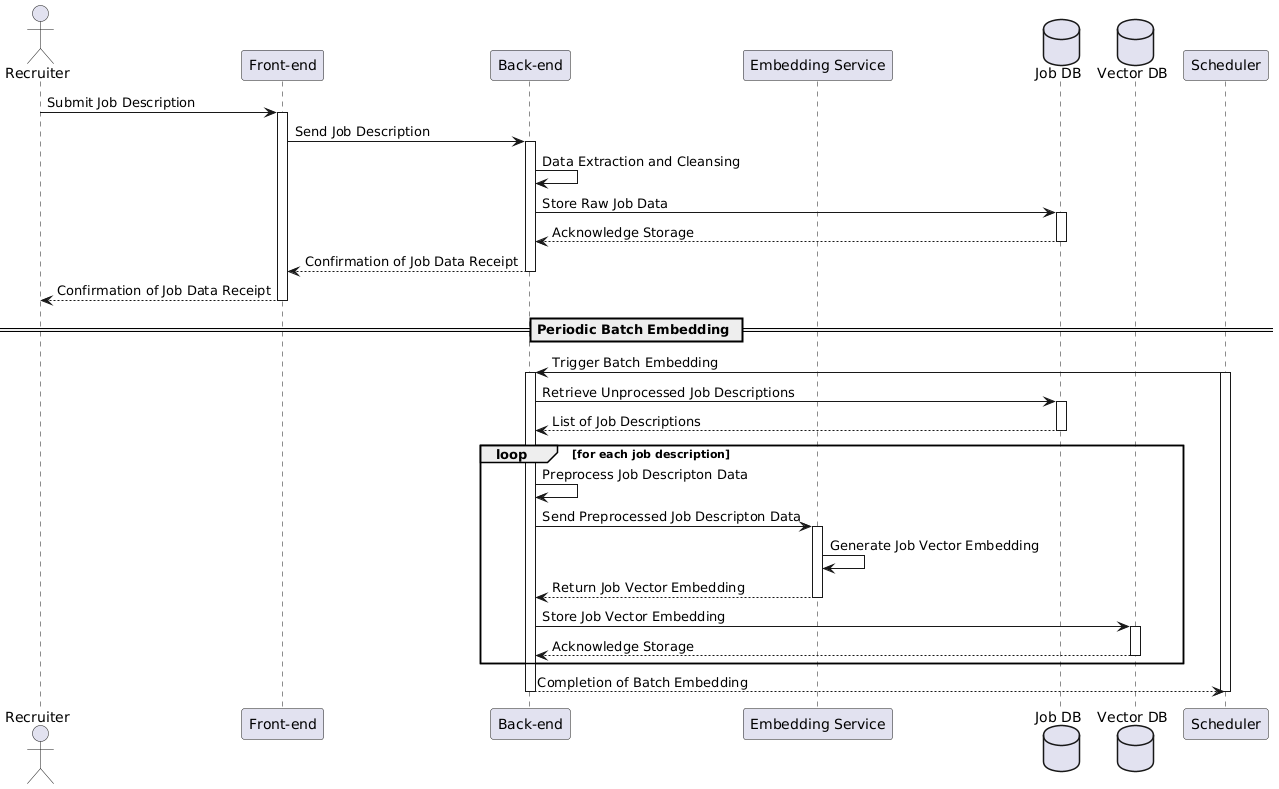



## Personalized Job Recommendation
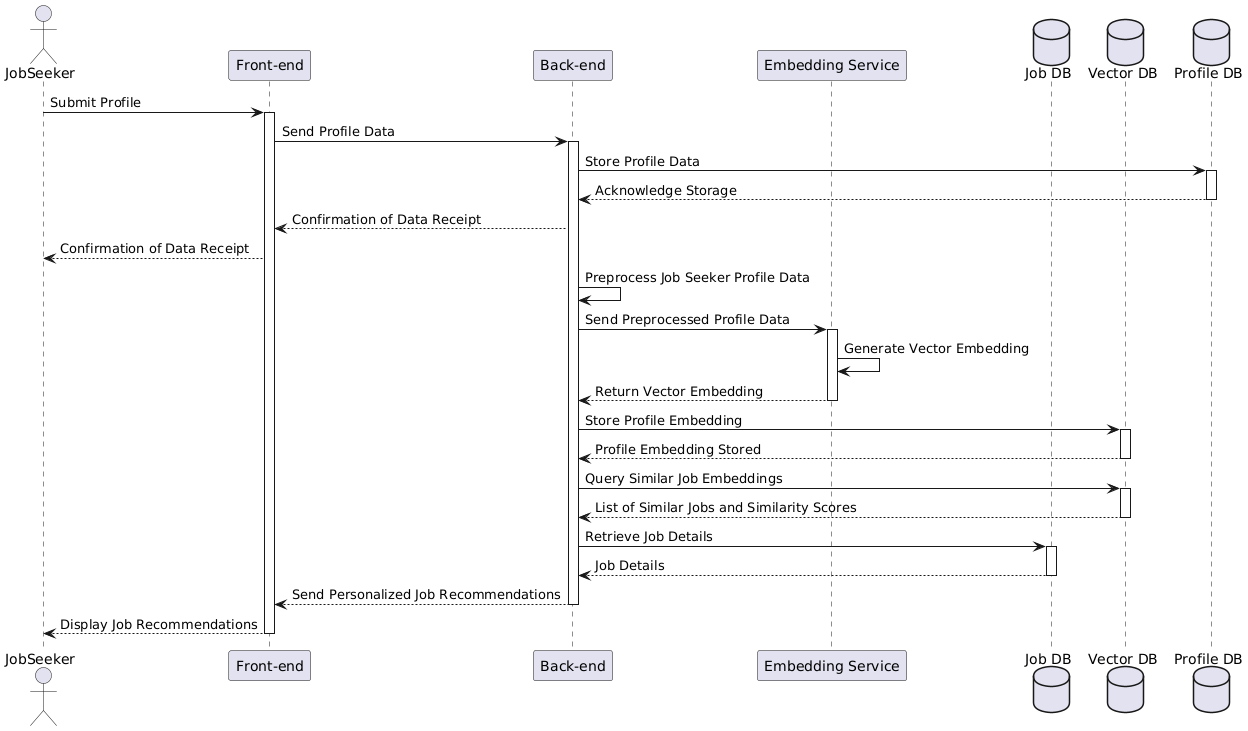

# Data Extraction and Preparation

> High-quality data is the foundation of any successful AI project. This section outlines the steps involved in acquiring, preparing, and transforming the job posting and resume data for our AI-powered matching system.

## Data Sources

*   **Job Postings:** We'll use a publicly available dataset of [LinkedIn job postings](https://www.kaggle.com/datasets/arshkon/linkedin-job-postings). This dataset provides a realistic snapshot of the current job market.
*   **Resumes:** We'll use a publicly available dataset of [resumes](https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset). This dataset includes resumes from a diverse range of professionals across various industries.

## Data Preprocessing

To ensure the system can effectively analyze and understand the data, we'll perform the following preprocessing steps:

*   **Data Cleaning:** Handle missing values and inconsistencies to improve data quality.
*   **Text Normalization:**  Standardize text fields (e.g., convert to lowercase, remove special characters) to reduce noise and improve matching accuracy.
*   **Feature Engineering:** Create a single, consolidated text field for each job posting and resume by combining key features like job title, description, and skills. This will provide a comprehensive representation of each item for embedding generation.

### Preprocessing Job Postings Data
**Step 1:** Load and Preview the Job Description Dataset

In [ ]:
# Download datasets from kaggle
!kaggle datasets download -d arshkon/linkedin-job-postings -f postings.csv
!kaggle datasets download -d snehaanbhawal/resume-dataset -f Resume/Resume.csv

Dataset URL: https://www.kaggle.com/datasets/arshkon/linkedin-job-postings
License(s): CC-BY-SA-4.0
postings.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset URL: https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset
License(s): CC0-1.0
 88% 7.00M/7.97M [00:00<00:00, 13.0MB/s]
100% 7.97M/7.97M [00:00<00:00, 10.3MB/s]


In [ ]:
!unzip postings.csv.zip
!unzip Resume.csv.zip

Archive:  postings.csv.zip
replace postings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  Resume.csv.zip
  inflating: Resume.csv              


In [ ]:
import pandas as pd
import os
import re

In [ ]:
# Load the Job Postings CSV file into a Pandas DataFrame
postings_df = pd.read_csv('postings.csv')

# Display the first few rows of the dataset to understand its structure
postings_df.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


In [ ]:
# Print number of rows and columns
postings_df.shape

(123849, 31)

**Step 2:** Reduce the dataset's size.
* Randomly selecting 1,000 rows for embedding generation.

In [ ]:
sampled_postings_df = postings_df.sample(1000)
sampled_postings_df.shape

(1000, 31)

**Step 3:** Normalize data and extract relevant features.


* Handling missing values.
* Normalizing text fields (e.g., removing punctuation, converting to lowercase).
* Create a single string representation of each resume by combining important features: title, description, skills_desc.

In [ ]:
def normalize_text(text):
    """Normalize text by converting to lowercase, removing special characters, and handling NaN."""
    if pd.isnull(text):
        return ""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s,+./-]', '', text)  # Remove unwanted characters but retain important ones like +, , . / -
    return text.strip()

def combine_postings_features(row):
    """Combine relevant features into a single string."""
    features = []
    for col in ['title', 'description', 'skills_desc']:
        if not pd.isnull(row[col]):
            features.append(f"{col.capitalize()}: {normalize_text(row[col])}\n")
    return ' '.join(features)

In [ ]:
# Create a new dataframe
preprocessed_postings_df = sampled_postings_df[['job_id']].copy()

# Apply preprocessing and feature combination
preprocessed_postings_df['combined_features'] = sampled_postings_df.apply(combine_postings_features, axis=1)

# Display the first 5 rows
preprocessed_postings_df.head()

,job_id,combined_features
22885,3889740167,Title: hospice registered nurse\n Description:...
32542,3894918876,Title: assistant project manager\n Description...
24394,3891010634,Title: quality control inspector\n Description...
68452,3902764114,"Title: brand specialist, amazon\n Description:..."
82397,3903887808,Title: weekend-only housekeeper\n Description:...


### Preprocessing Resume Data
**Step 1:** Load and Preview the Job Description Dataset

In [ ]:
resume_df = pd.read_csv('Resume.csv')

# Display the first few rows of the dataset to understand its structure
resume_df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [ ]:
# Print number of rows and columns
resume_df.shape

(2484, 4)

**Step 2:** Reduce the dataset's size.
* Randomly selecting 1,000 rows.

In [ ]:
sampled_resume_df = resume_df.sample(1000)
sampled_resume_df.shape

(1000, 4)

**Step 3:** Normalize data
* We will apply the same normalization steps as the job postings dataset. Since the 'Resume_str' already contains the cosolidated text for resumes, feature combination is not necessary.

In [ ]:
# Apply normalization
sampled_resume_df['normalized_resume'] = sampled_resume_df['Resume_str'].apply(normalize_text)

# Display the first 5 rows
sampled_resume_df[['ID', 'normalized_resume']].head()

,ID,normalized_resume
1164,29647215,consultant career overview ten ye...
1526,18640927,finance manager summary ability to co...
54,18422164,hr specialist summary results-driven ...
341,29797594,teacher skills e ducator people ...
2313,28629430,creative director career focus crea...


# Job Recommendation System using Embeddings
> This section outlines the process of generating embeddings for preprocessed job postings and resumes, and using these embeddings to identify relevant job matches. It leverages the Voyage API for embedding generation and cosine similarity for measuring the similarity between jobs and resumes.

## Generating and Storing Job Posting Embeddings
* Generate embeddings for job postings using Voyage and a custom ChromaDB function.
* Store the generated embeddings in the vector database.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install python-dotenv
!pip install voyageai
import voyageai
import os
import dotenv

dotenv.load_dotenv('/content/drive/MyDrive/Projects/Job_Recommendation_System/.env')

# Get Voyage API Key
VOYAGE_API_KEY = os.environ.get('VOYAGE_API_KEY')

# Initialize the API client and define embedding model
vo = voyageai.Client(api_key=VOYAGE_API_KEY)
embedding_model = "voyage-3-lite"

In [ ]:
!pip install chromadb
!pip install voyageai
import chromadb
from chromadb import Documents, EmbeddingFunction, Embeddings

# Create custom embedding function for ChromaDB
class VoyageEmbeddingFunction(EmbeddingFunction):
    def __init__(self, batch_size=128, model=None):
        self.batch_size = batch_size
        self.model = model
        if self.model is None:
            raise ValueError("Model must be specified")

    def __call__(self, input: Documents) -> Embeddings:
        all_embeddings = []
        for i in range(0, len(input), self.batch_size):
            batch = input[i : i + self.batch_size]
            try:
                result = vo.embed(batch, model=self.model, input_type="document")
                all_embeddings.extend(result.embeddings)
            except Exception as e:
                print(f"Error generating embeddings: {e}")
                return None  # Or raise the exception if you prefer
        return all_embeddings

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.3/628.3 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 49.9 MB/s eta 0:00:00
 

In [ ]:
# Create a ChromaDB client
client = chromadb.Client()

voyage_ef = VoyageEmbeddingFunction(model=embedding_model)

# Create a collection for job postings
collection = client.create_collection(
    "job_postings",
    embedding_function=voyage_ef
)

In [ ]:
# Add data to the collection
collection.add(
    documents=preprocessed_postings_df['combined_features'].tolist(),
    ids=preprocessed_postings_df['job_id'].astype(str).tolist(),
)

## Retrieving Job Recommendations
This section demonstrates retrieving job recommendations for a given resume using the vector database.

* Specify the resume for which recommendations are desired.
* Execute a similarity search against the vector database.
* Present the top 3 most relevant job recommendations.

In [ ]:
# Find top 3 similar jobs for the first resume in the resume dataset
first_resume = sampled_resume_df.iloc[0]['normalized_resume']

print("Top job matches for resume:")
print(first_resume)
print("-" * 50)  # Separator

# Perform the query
query_results = collection.query(
    query_texts=[first_resume],
    n_results=3,
)

def print_query_results(results):
    """Prints ChromaDB query results in a more readable format."""

    if not results:
        print("No results found.")
        return

    for i, (ids, distances, metadatas, documents) in enumerate(zip(
        results["ids"], results["distances"], results["metadatas"], results["documents"]
    )):
        print(f"\nResult Set {i+1}:")
        for j, (id, distance, metadata, document) in enumerate(zip(ids, distances, metadatas, documents)):
            print(f"  Result {j+1}:")
            print(f"    ID: {id}")
            print(f"    Distance: {distance}")
            print(f"    Document: {document}")
            if metadata:  # Check if metadata exists
                print("    Metadata:")
                for key, value in metadata.items():
                    print(f"      {key}: {value}")
            else:
                print("    No Metadata")

print_query_results(query_results)


Top job matches for resume:
consultant           career overview    ten years of experience with cerner implementations as a consultant and employee. experience with all phases of implementation from current state workflows to conversion for inpatient and outpatient hospitals/clinics. skilled in initiating and leading implementations involving rollout of multiple ambulatory clinics within a 1-2 month timeframe. skilled in implementations for inpatient hospitals. experience in designing and building multiple components of powerchart/powerchart office/enhanced view applications to include inbox/message center, schedule viewer, powerorders, powerplans, zynx auto space, caresets, charges, task lists, easyscript, mar, all profiles, powerforms, clinical notes, powernotes, dynamic documentation, bedrock, data collection worksheet, change control process, workflow process, eprescribe, and set-up of all reference and privileges. determine estimate cost for various projects.       qualifications

# Conclusion and Broader Applications

This notebook demonstrates how embeddings and vector databases can power a robust job recommendation system, enabling seamless matching between job seekers and opportunities. By leveraging advanced embedding techniques and tools like ChromaDB, we efficiently matched resumes with relevant job postings based on semantic similarity.

## Broader Applications of Embeddings and Vector Databases

While this implementation focused on job recommendations, embeddings and vector databases can enhance other features within a job platform, such as:

* **Enhanced Job Search:** Implement semantic search to help job seekers find opportunities that align with their experience, even when job titles differ.

* **Recruiter Tools for Talent Matching:** Recruiters can leverage embeddings to match job descriptions with a pool of resumes or candidate profiles for a perfect fit.

By integrating these advanced applications, job platforms can provide a richer and more personalized user experience, driving better outcomes for both job seekers and employers.